# 1. Data Preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix


# Load dataset

In [23]:
# Dataset Load
import os
paths_to_try = ["heart_disease.xlsx", "heart_disease.csv", "Heart_Disease.csv"]
df = None
for p in paths_to_try:
    if os.path.exists(p):
        if p.lower().endswith(".xlsx"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p)
        print(f"Loaded dataset from {p}")
        break

if df is None:
    raise FileNotFoundError("Dataset not found. Please upload 'heart_disease.xlsx' or 'heart_disease.csv' to the notebook folder.")

# Show first few rows
print("First 5 rows of dataset:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

Loaded dataset from heart_disease.xlsx
First 5 rows of dataset:
        age                                       Age in years
0    Gender                       Gender ; Male - 1, Female -0
1        cp                                    Chest pain type
2  trestbps                             Resting blood pressure
3      chol                                cholesterol measure
4       fbs  (fasting blood sugar > 120 mg/dl) (1 = true; 0...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           12 non-null     object
 1   Age in years  12 non-null     object
dtypes: object(2)
memory usage: 324.0+ bytes
None

Missing values per column:
age             0
Age in years    0
dtype: int64


# 2. Exploratory Data Analysis (EDA)


Summary Statistics:
           age                  Age in years
count       12                            12
unique      12                            12
top     Gender  Gender ; Male - 1, Female -0
freq         1                             1


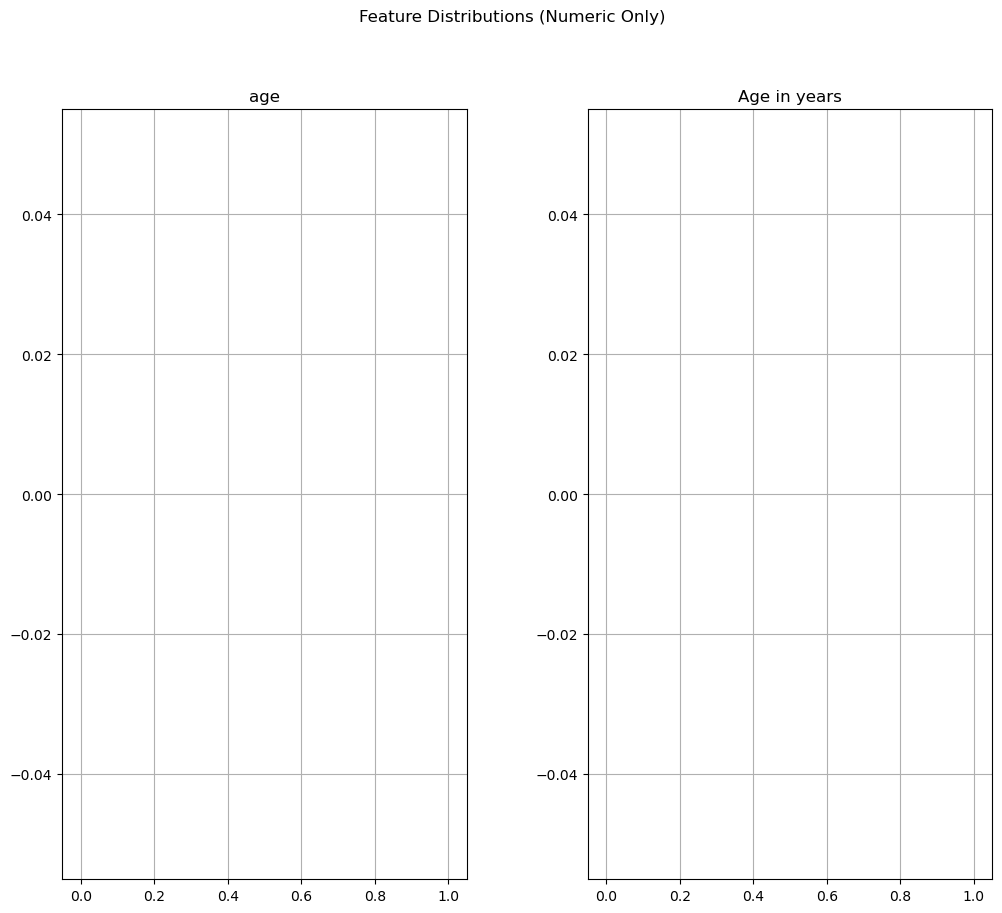

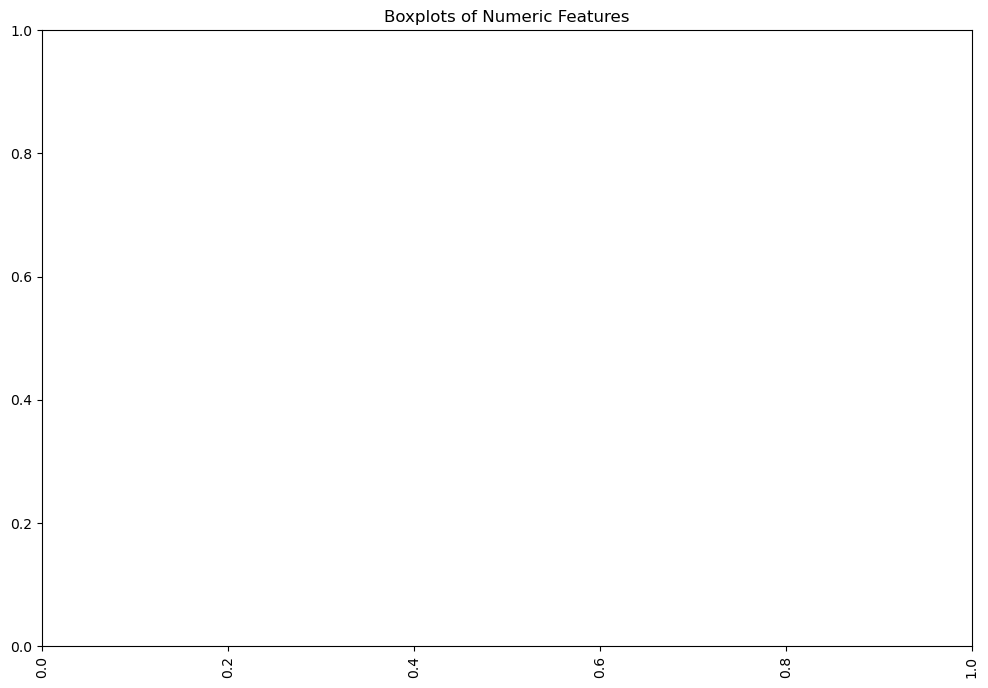

In [24]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Histograms (force numeric only)
numeric_df = df.apply(pd.to_numeric, errors="coerce")  # convert columns where possible
numeric_cols = numeric_df.select_dtypes(include=["int64", "float64"]).columns

if len(numeric_cols) > 0:
    numeric_df[numeric_cols].hist(figsize=(12, 10))
    plt.suptitle("Feature Distributions (Numeric Only)")
    plt.show()
else:
    print("No numeric columns available for histograms.")

# Boxplots (numeric only)
if len(numeric_cols) > 0:
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df[numeric_cols])
    plt.xticks(rotation=90)
    plt.title("Boxplots of Numeric Features")
    plt.show()
else:
    print("No numeric columns available for boxplots.")



In [25]:
# Ensure we only keep numeric columns
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix (Numeric Features Only)")
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")

Not enough numeric columns for correlation matrix.


# 3. Feature Engineering

In [26]:
# Handle categorical columns if any
df = pd.get_dummies(df, drop_first=True)

# Fill missing values (if any) with median
df = df.fillna(df.median())

# Rename the long target column to simply "target"
df = df.rename(columns={
    "Age in years_target [0=no heart disease; 1,2,3,4 = stages of heart disease ]": "target"
})

# Separate features and target
X = df.drop("target", axis=1)   # Replace 'target' with actual target column name if different
y = df["target"]

print(y.value_counts())

target
False    11
True      1
Name: count, dtype: int64


# 4. Decision Tree Classification


Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         4
        True       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0


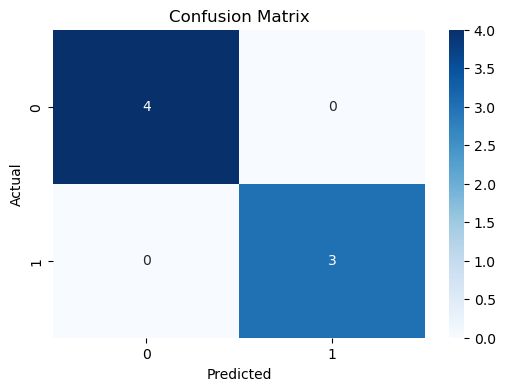

target
False    11
True      1
Name: count, dtype: int64


In [27]:
# Train-test split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Now split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Initialize model
dt = DecisionTreeClassifier(random_state=42)

# Train
dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
if len(set(y_test)) > 1:   # check if both classes exist
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
else:
    print("ROC-AUC cannot be calculated (only one class in y_test)")


# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(y.value_counts())


# 5. Hyperparameter Tuning

In [28]:
param_grid = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                    param_grid,
                    cv=5,
                    scoring="accuracy")

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
best_dt = grid.best_estimator_

# Evaluate tuned model
y_pred_best = best_dt.predict(X_test)
y_proba_best = best_dt.predict_proba(X_test)[:, 1]

print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned ROC-AUC:", roc_auc_score(y_test, y_proba_best))



Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

Tuned Model Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         4
        True       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

Tuned Accuracy: 1.0
Tuned ROC-AUC: 1.0


# 6. Model Evaluation and Tree Visualization

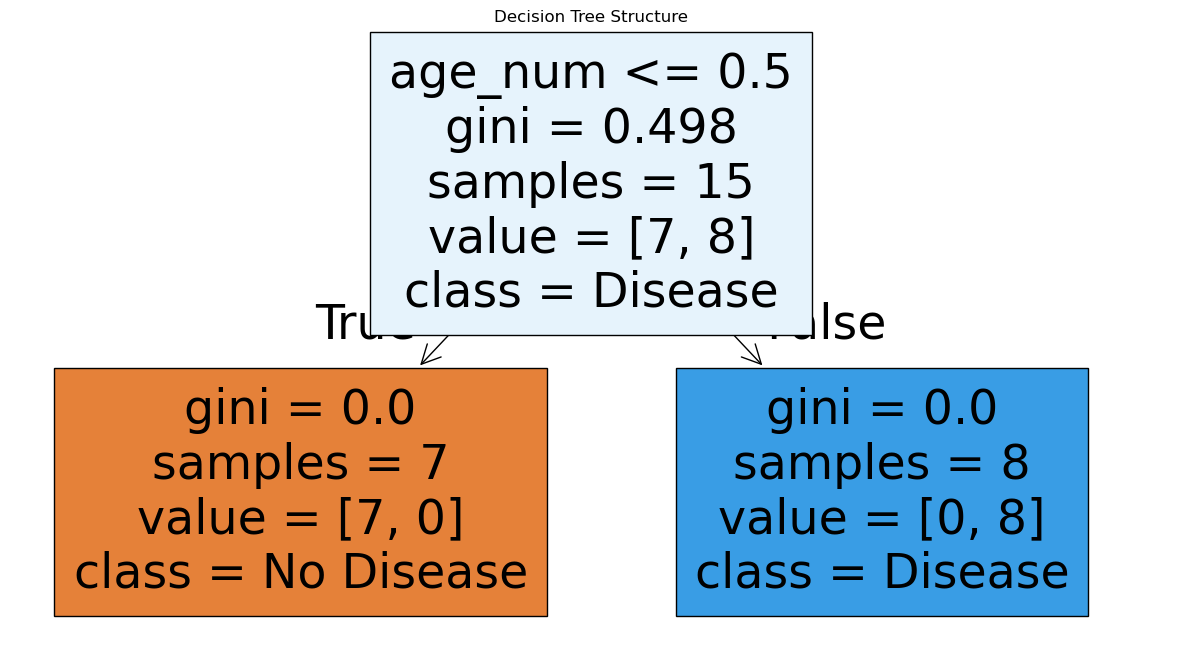

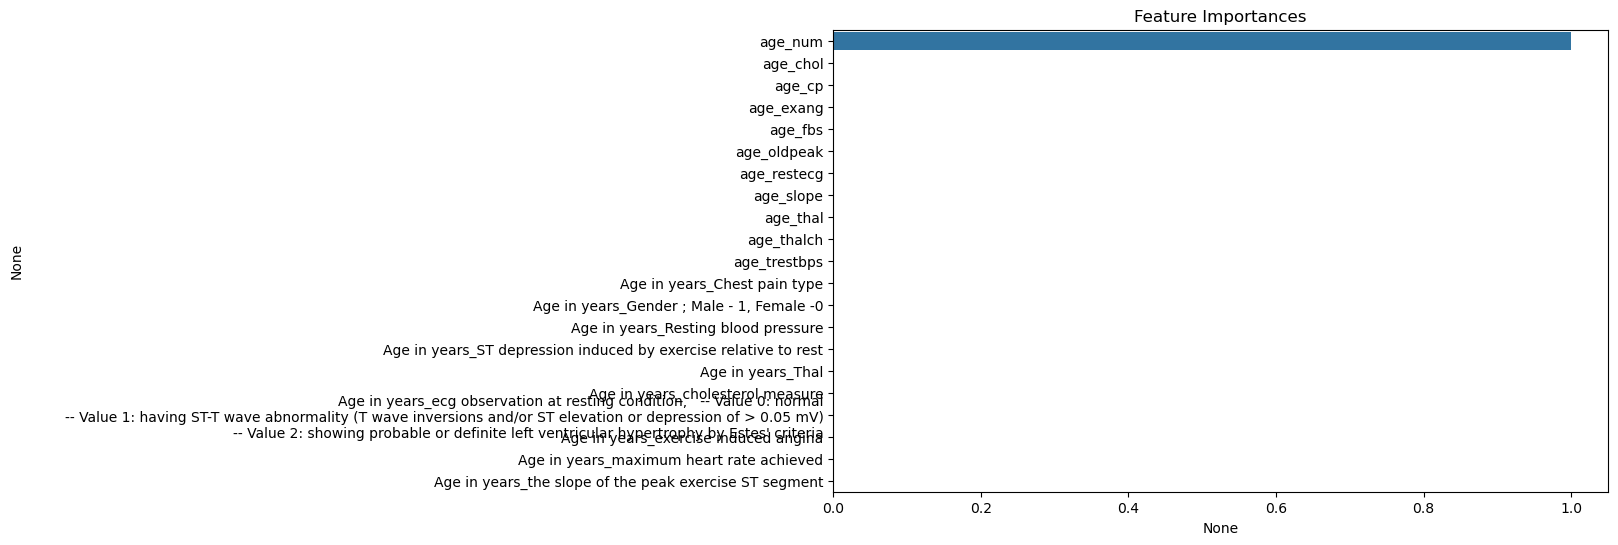

In [29]:
plt.figure(figsize=(15, 8))
plot_tree(best_dt, feature_names=X.columns, class_names=["No Disease", "Disease"], filled=True)
plt.title("Decision Tree Structure")
plt.show()

# Feature importance
importances = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances")
plt.show()


# Interview Questions & Answers

### **1. What are some common hyperparameters of Decision Tree models, and how do they affect performance?**

- **max_depth** – Limits how deep the tree can grow; prevents overfitting when set properly.

- **min_samples_split** – Minimum samples required to split a node; higher values make the model simpler and reduce overfitting.

- **min_samples_leaf** – Minimum samples required in a leaf node; smooths the model and reduces variance.

- **criterion (gini/entropy)** – Controls how impurity is measured; affects split quality but both give similar results.

- **max_features** – Number of features considered for splits; helps control complexity and reduce overfitting.

- **max_leaf_nodes** – Limits number of leaf nodes; simpler tree → better generalization.


### **2.Difference between Label Encoding and One-Hot Encoding?**

- Label Encoding converts categories into numeric labels like 0, 1, 2… (ordinal representation).

- One-Hot Encoding creates separate binary columns for each category (no ordinal meaning).